<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Examine-data" data-toc-modified-id="Examine-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Examine data</a></span><ul class="toc-item"><li><span><a href="#Plot-the-data" data-toc-modified-id="Plot-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plot the data</a></span></li></ul></li><li><span><a href="#Decompose-data" data-toc-modified-id="Decompose-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Decompose data(EDA)</a></span><ul class="toc-item"><li><span><a href="#Decompose-with-Statsmodels" data-toc-modified-id="Decompose-with-Statsmodels-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Decompose with Statsmodels</a></span></li></ul></li><li><span><a href="#Stationarity" data-toc-modified-id="Stationarity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Stationarity</a></span><ul class="toc-item"><li><span><a href="#Augmented-Dickey-Fuller-test" data-toc-modified-id="Augmented-Dickey-Fuller-test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Augmented Dickey-Fuller test</a></span></li><li><span><a href="#Differencing" data-toc-modified-id="Differencing-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Differencing</a></span></li></ul></li><li><span><a href="#Autocorrelations-and-Choosing-Model-Order" data-toc-modified-id="Autocorrelations-and-Choosing-Model-Order-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelations and Choosing Model Order</a></span></li><li><span><a href="#Fitting-an-model" data-toc-modified-id="Fitting-an-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting a model (MLP)</a></span><ul class="toc-item"><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Basic Analytics</a></span></li><li><span><a href="#SARIMAX-Model" data-toc-modified-id="SARIMAX-Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Model Development</a></span></li><li><span><a href="#Grid-search" data-toc-modified-id="Grid-search-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Grid search</a></span></li><li><span><a href="#Fitting-the-SARIMAX-Model" data-toc-modified-id="Fitting-the-SARIMAX-Model-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Model-Accuracy:-Mean-squared-error-(MSE)" data-toc-modified-id="Model-Accuracy:-Mean-squared-error-(MSE)-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Forecasts</a></span></li></ul></li></ul></div>

# 1-Examine Data:

In [24]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# seed configuration
np.random.seed(38)
torch.manual_seed(38)

In [13]:
#load the dataset
gold = pd.read_csv('data/gold_price_data.csv')
#convert the 'Date' column of the gold dataframe to a datetime
gold['Date'] = pd.to_datetime(gold['Date'], errors='coerce')#errors='coerce',NaT(Not a Time)
gold

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [14]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10787 non-null  datetime64[ns]
 1   Value   10787 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.7 KB


In [15]:
gold.describe

<bound method NDFrame.describe of             Date    Value
0     1970-01-01    35.20
1     1970-04-01    35.10
2     1970-07-01    35.40
3     1970-10-01    36.20
4     1971-01-01    37.40
...          ...      ...
10782 2020-03-09  1672.50
10783 2020-03-10  1655.70
10784 2020-03-11  1653.75
10785 2020-03-12  1570.70
10786 2020-03-13  1562.80

[10787 rows x 2 columns]>

In [16]:
gold.shape

(10787, 2)

** Checking the Null Values:

In [17]:
print(gold.isnull().sum())


Date     0
Value    0
dtype: int64


** Checking the duplicated values:

In [18]:
gold.duplicated().sum()

0

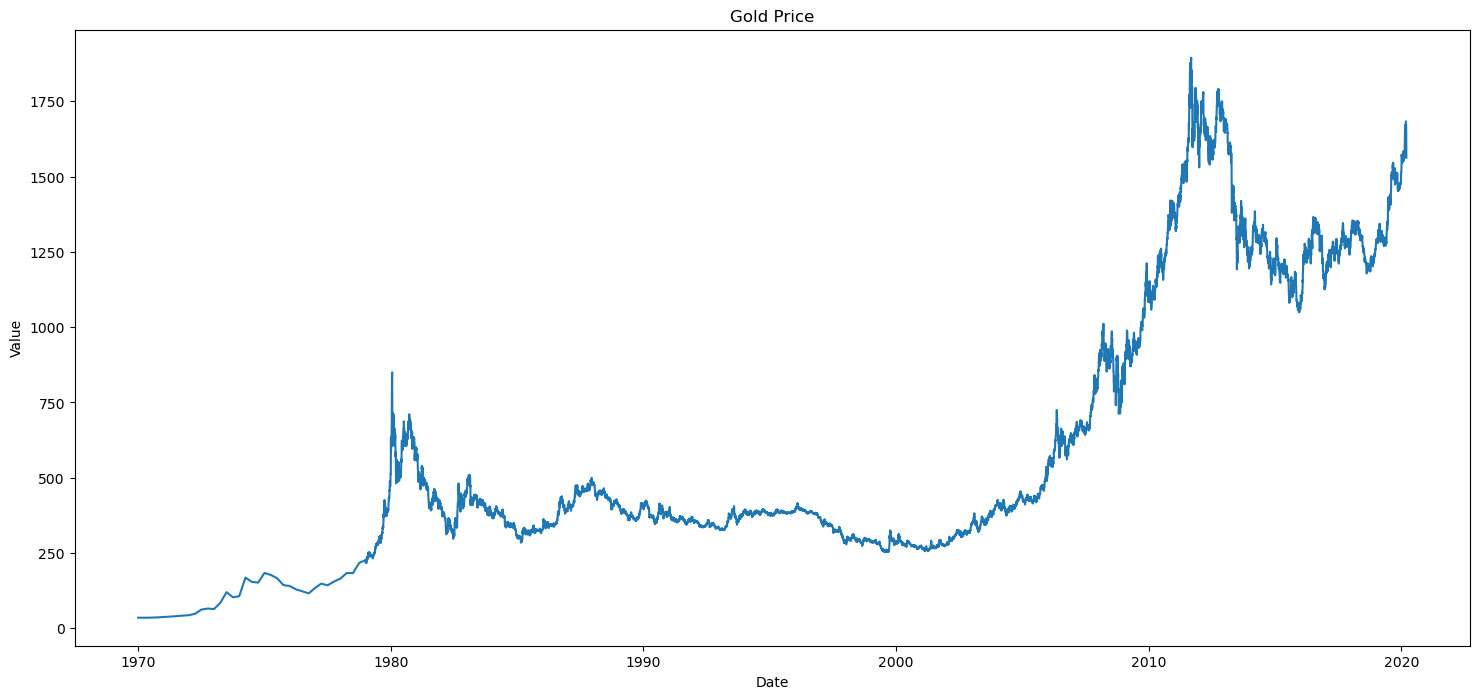

In [21]:
plt.figure(figsize = (18,8))
sns.lineplot(data=gold, x="Date", y="Value")
plt.title('Gold Price')
plt.show()

# 2-Decomposing Data with Statsmodels EDA (Exploratory Data Analysis):

Time series decomposition -

1. **Trend** - Slow moving changes in a time series, Responisble for making series gradually increase or decrease over time.
2. **Seasonality** - Seasonal Paterns in the series. The cycles occur repeatedly over a fixed period of time.
3. **Residuals** - The behaviour of the time series that cannot be explained by the trend and seasonality components. Also called random errors/white noise.

### See Time Series Components (Trend, Seasonality,Residuals)

In [22]:
gold_eda = gold.copy()
gold_eda.set_index('Date', inplace=True)

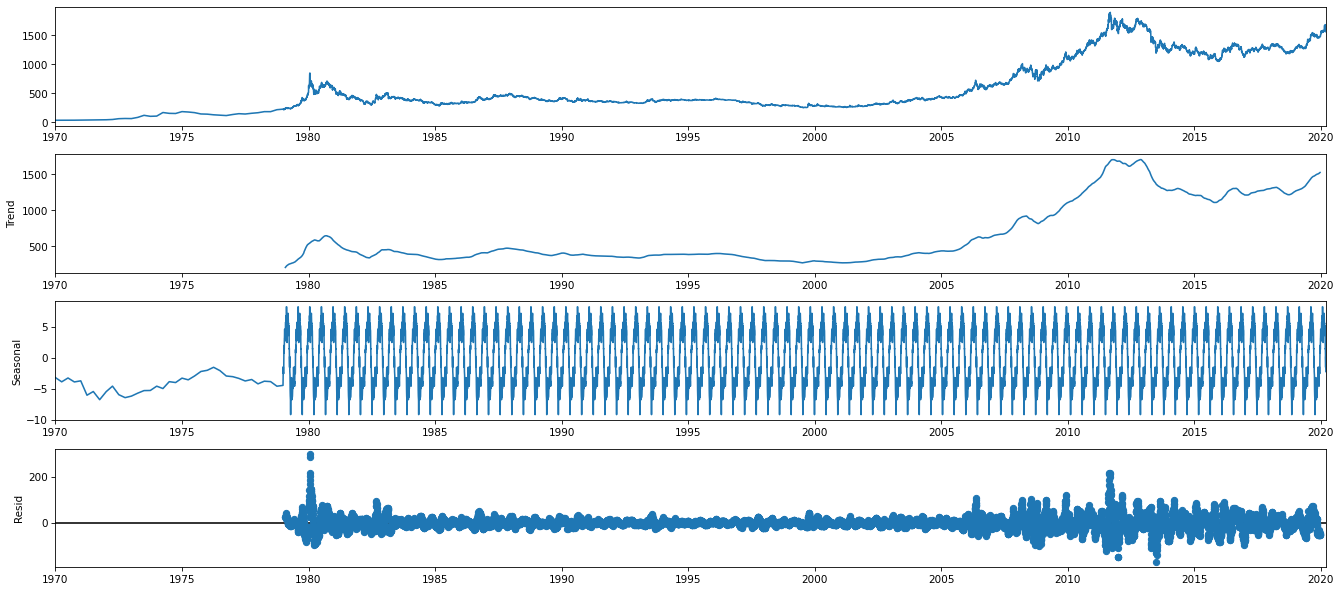

In [25]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_eda, model='additive', period=120)
result.plot()
plt.show()

# 3-Stationarity:

### Data Splitting
- I decide to split data into 75:25

In [10]:
X_train = gold[:8090]
X_test = gold[8090:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (8090, 2)
X_test Shape (2697, 2)


### Forecasting For Nine Months Ahead

In [11]:
X_train = X_train[['Date', 'Value']]
X_test = X_test[['Date', 'Value']]

X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)

In [12]:
index_9_months = pd.date_range(X_test.index[-1], freq='MS', periods=9)
index_9_months

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

## Define d Using ADF Test
- pvalue = 0.05

In [13]:
def define_d(data):
    X_train = adfuller(data, autolag='AIC')
    adf = X_train[0]
    pvalue = X_train[1]
    critical_value = X_train[4]['5%']
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations', 'Critical Value']
    for value,label in zip(X_train,labels):
        print(label+' : '+str(value) )

    if (pvalue < 0.05):
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")

define_d(X_train)

ADF Test Statistic : 0.7111393941300093
p-value : 0.9900575735401028
#Lags Used : 36
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Indicating It Is Non-Stationary **


## Differencing

In [14]:
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic : -15.695627256339964
p-value : 1.4163027798506914e-28
#Lags Used : 35
Number of Observations : 8053
Critical Value : {'1%': -3.431162291775169, '5%': -2.861898975088068, '10%': -2.566961077711922}
** Data Is Stationary **


# 4-Autocorrelations and Choosing Model Order :

### Define p and q using PACF and ACF plot

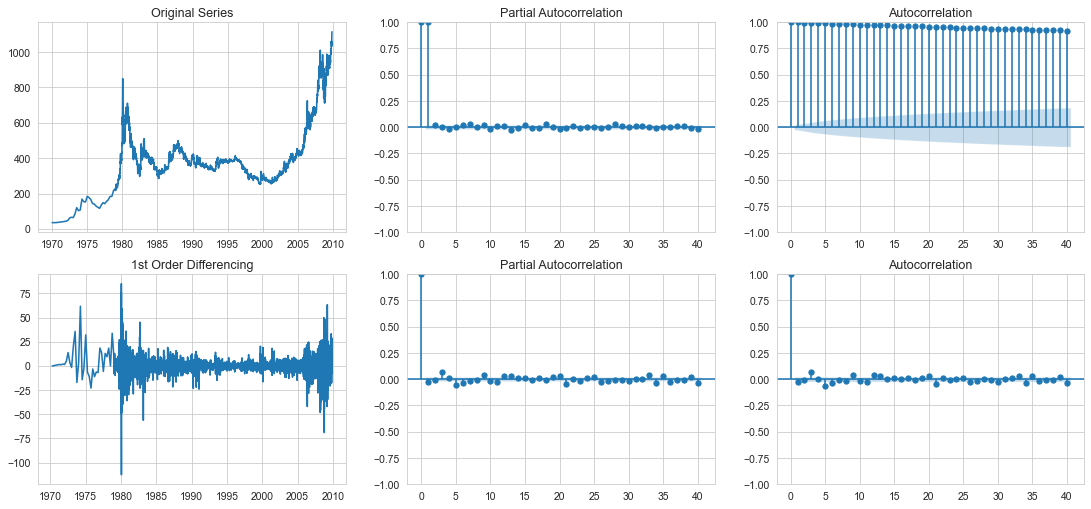

In [15]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(X_train); axes[0, 0].set_title('Original Series')
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(X_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show()

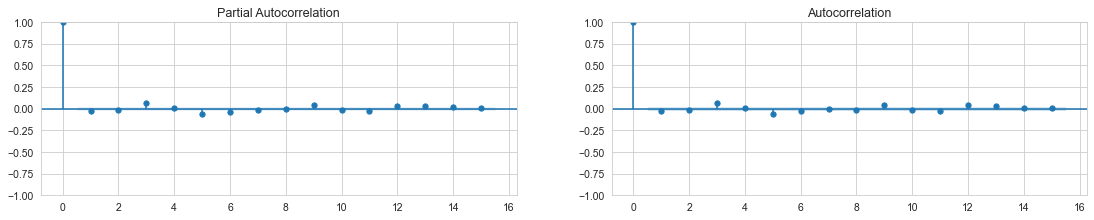

In [16]:
plt.rcParams.update({'figure.figsize':(18,3), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
plot_pacf(X_train.diff().dropna(), lags = 15, ax=ax[0])
plot_acf(X_train.diff().dropna(), lags = 15, ax=ax[1])
plt.show()

    Based on PACF and ACF, I define p = 0 and q = 0

# 5-Fitting a model:

## MLP (Multilayer Perceptron model)

### a.Basic Analytics :

 <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [11]:
gold.head(15)

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4
5,1971-04-01,38.9
6,1971-07-01,40.1
7,1971-10-01,42.0
8,1972-01-03,43.5
9,1972-04-03,48.3


In [ ]:
# compute dtype
for column in gold.columns:
    print(f"The data type for '{column}' column is: {gold[column].dtype}")

The data type for 'Date' column is: datetime64[ns]
The data type for 'Value' column is: float64


In [ ]:
# compute descriptive statistics
gold.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


The descriptive statistics computed are the mean, standard deviation, minimum and maximum values. We see that the maximum value is 1895.00 and minimum value is 35.10, and the standard deviation is 148.94. This shows that the sales volume varies by a large spread. Next, we will plot a time plot for the data.

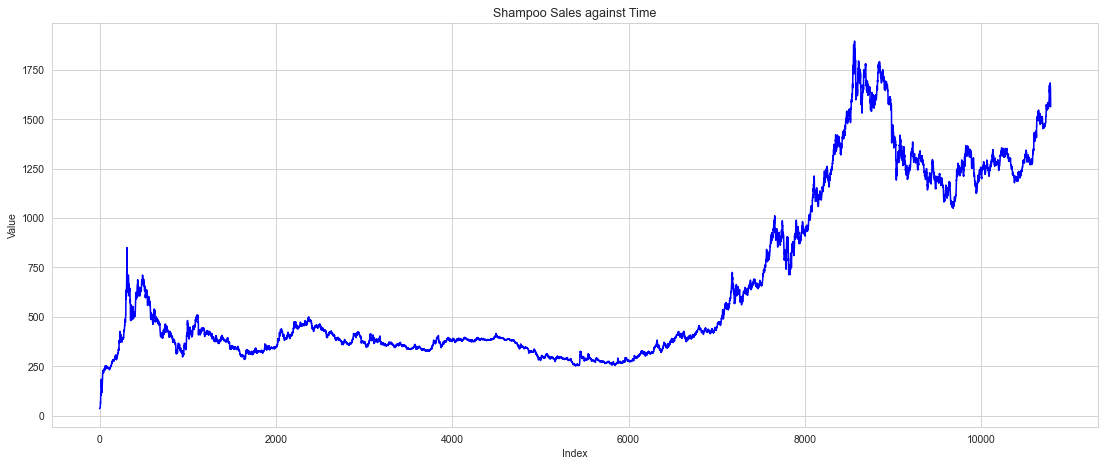

In [ ]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    gold['Value'],
    color='blue', label='Data');

Now that we get to feel the ebb and flow of the data. Let's split the dataset into training and test set.

In [23]:
# split dataset
df_train, df_test = train_test_split(gold, train_size=0.7, shuffle=False)

# display training dataset length
print(f"The length of training dataset is: {len(df_train)}")

# display test dataset length
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 7550
The length of test dataset is: 3237


Let's see what are the portion of dataset which is splitted as training dataset and test dataset.

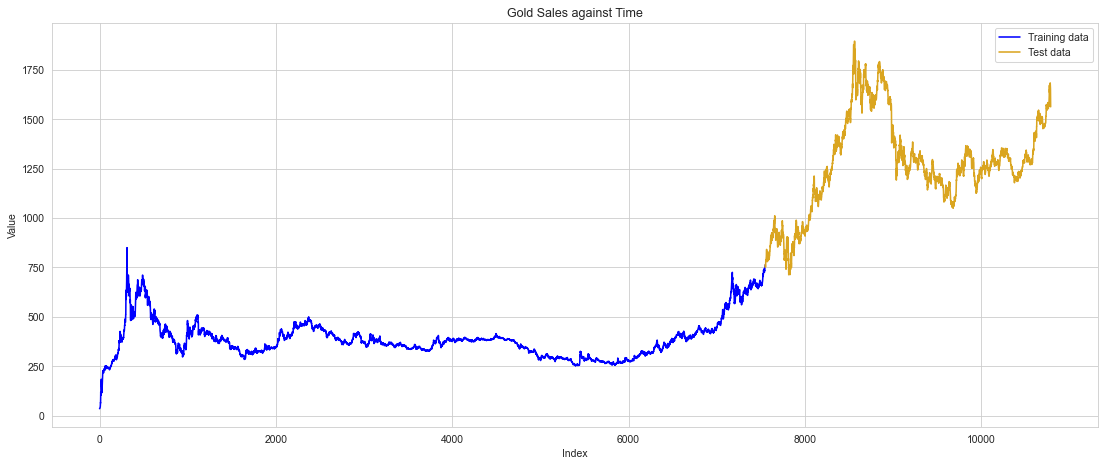

In [24]:
# plot time plot for training and test dataset 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_train['Value'],
    color='blue', label='Training data');
ax.plot(
    df_test['Value'],
    color='goldenrod', label='Test data')
ax.legend();

Feature scalinng also help in shortening model training time. Let's do that too.

In [25]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['Value'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['Value'].values.reshape(-1,1))

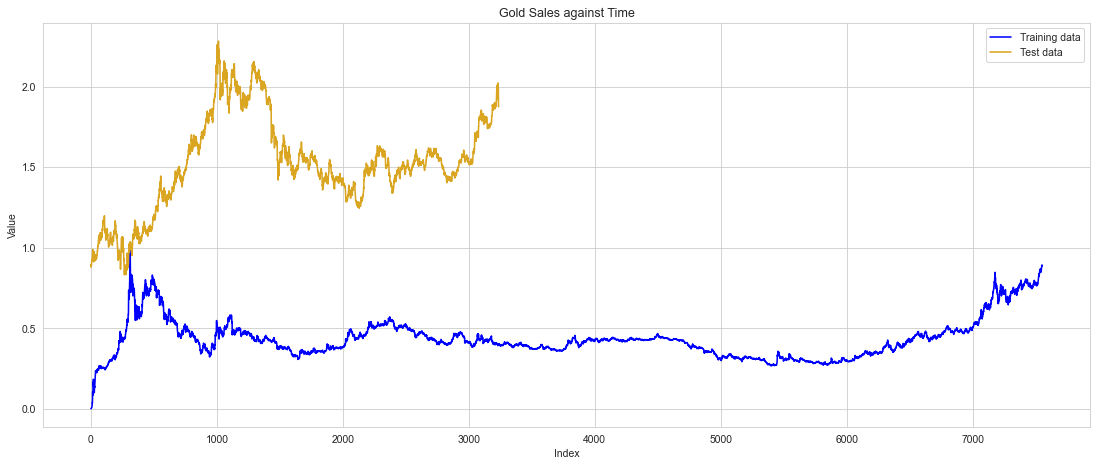

In [26]:
# test de scaler:
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    train_scaled,
    color='blue', label='Training data');
ax.plot(
    test_scaled ,
    color='goldenrod', label='Test data')
ax.legend();

**==> L' objectif du scaler c'est la mise à l'échelle et c'est tres important car si je veux comparer entre deux choses, je dois les mettre dans le meme echelle pour voir les deux avec la meme importance .**

### b.Model Development

The `torch` library provides a number of API to easily construct a MLP model for the tasks at hand. But first, we will need to prepare the dataset into a format ingestible by the model first. We will first transform the time series data into feature of label, where the feature would be a sequence of *n* length of data and label would be lead-1 of the last data in the feature.

In [27]:
#c'est la plus importante partie du time series : le sequensage, on decoupe la sequences des données en des periodes de 4 , on a 3 parametres(données) pour predire le 4éme 
#afin d'avoir une matrice a partir d'un tableau et apres les injecter.
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
# 3 est la taille de fenetre pour le sequensage ( no underfitting ni overfitting c'est juste la valeur q'on prend pour predire par exemple 3 jours pour predire la temperature )
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 3)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 3) # 3 ou 7 c'est divisible par 365 c'est la taille de sequence
                                                                    #qu'on va l'injecter en transposée 1 par 1 et obtenir une matrice


# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 7547
Total samples for y train: 7547
Total samples for X test: 3234
Total samples for y test: 3234


Let's write a custom `Dataset` class to transfrom the data into tuples of `torch.Tensor`. This is necessary if we want to load the data in batches using `DataLoader`.

In [28]:
class GoldDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """ 
    # Pytorch/ tensorflow optimise le calcul en decoupant les données en des vecteur float tensor(matrice) c-a-d les mettre en ptit portions pour accelerer la processus 
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

We will write the codes to convert data into `Dataset` object and then into `DataLoader` object. We will be using a batch size of 4 for this `DataLoader` object.

In [29]:
# declare batch size 
batch_size = 4

# convert into Dataset using customized class
train_Dataset = GoldDataset(X_sequence_train, y_sequence_train)
test_Dataset = GoldDataset(X_sequence_test, y_sequence_test)

# convert into DataLoader
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)
#shuffle=False is used for test_loader to keep the testing data in the original order.

#==> convertir puis charger les données
# declare a dict object
dataloaders = {'train': train_loader, 'test': test_loader} 

It's about time to declare our MLP model architecture. The following code demonstrates how to build a simple MLP model.

In [30]:
# define MLP model architecture
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    ### BEGIN SOLUTION
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        #input+1er couche
        self.input = nn.Linear(input_size, 64)
        #2eme couche
        self.linear1 = nn.Linear(64, 16)
        #output
        self.output = nn.Linear(16, output_size)
         
    
    def forward(self, x):
        x = x.view(-1, 1, 7) # 7 input size
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out
    
    # c'est transormer les data sous forme de torche car y'a des données tres longues , a but charger decharger lire les data en parllele et rapidement
    # on a input , on a layer1 64 noeuds, layer2 16 noeuds puis l'output qui sont liées tous entre elles et ont chacunes un  poids weights

Before we can start our training, we also need to configure some hyperparameters. Let's do that.

In [31]:
# reproducibility
torch.manual_seed(38)

# setting hyperparameter
input_size = 3
output_size = 1
epochs = 100
learning_rate = 0.001

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We can perform our model training now. In `torch`, we need to manually write codes to implement model training.

In [32]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)


We can plot the loss score to check how is the model performing when trained by epochs.

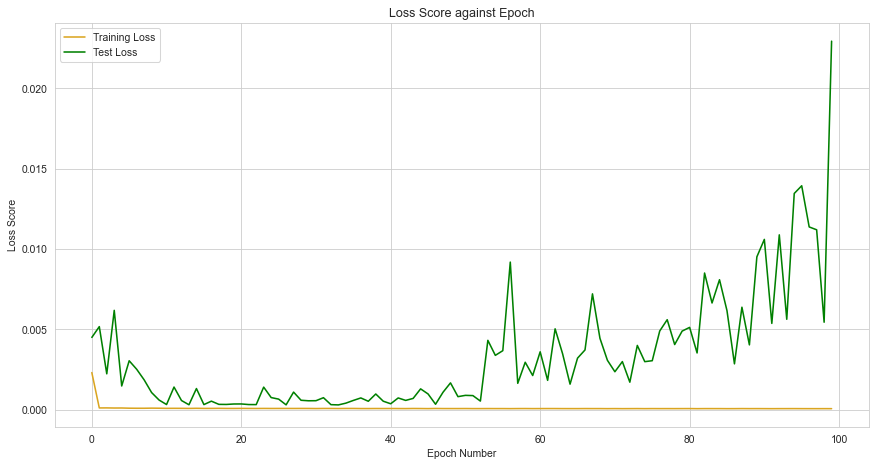

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

### c. Evaluation

There are a few metrics that can be used to evaluate the performance of a regression model, which include:
* mean squared error (MSE)
* root mean squared error (RMSE)
* mean absolute error (MAE)

We will examine the performance of the model on test set using RMSE. 

In [34]:
#on doit reinitialiser les df_train et df_test
df_train, df_test = train_test_split(gold, train_size=0.7, shuffle=False)


# model predictions
model.eval()
predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[3:]
df_test['preds'] = predictions.squeeze()

# compute MSE
RMSE = mean_squared_error(df_test.preds, df_test.Value, squared=False)
print(f"The RMSE for the model is {RMSE}")

The RMSE for the model is 123.40190065394593


We can also print and visualize predictions made by the model for inspection purpose.

7553      733.328728
7554      737.770427
7555      737.889816
7556      746.196861
7557      757.099390
            ...     
10782    1489.654798
10783    1478.370980
10784    1462.038801
10785    1461.270978
10786    1390.082945
Name: preds, Length: 3234, dtype: float64


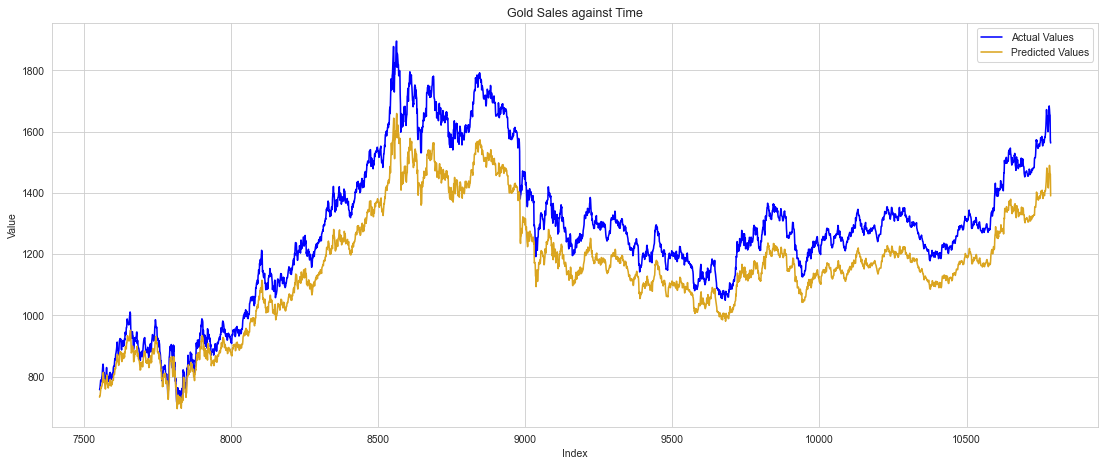

In [35]:
# print prediction results
print(df_test['preds'])


# plot time plot for predictions and ground truth 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Gold Sales against Time")
ax.grid(True)
ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    df_test['Value'],
    color='blue', label='Actual Values');
ax.plot(
    df_test['preds'],
    color='goldenrod', label='Predicted Values')
ax.legend();


## <a name="reference">Reference</a>
1. [Pytorch](https://pytorch.org/)

**Exemple resuming Neural networks architecture:**


<img src="images/Ai-Neural-Network.gif"
     alt="Markdown Monster icon"
     style=" width:fit-content !important;margin-left:32% !important;" />